In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

['allenai_unifiedqa', 'cointegrated_rubert', 'csebuetnlp_banglat5', 'dandelin_vilt', 'alisawuffles_roberta', 'Davlan_multilingual', 'emrecan_bert', 'KB_bert', 'nbroad_ESG-BERT', 'SCUT-DLVCLab_lilt-roberta', 'ai-forever_sbert', 'amberoad_bert', 'Babelscape_rebel', 'castorini_msmarco', 'dccuchile_bert', 'DeepMount00_Llama', 'edumunozsala_roberta', 'Elron_bleurt', 'EmbeddedLLM_bge', 'eugenesiow_bart-paraphrase', 'facebook_hubert', 'facebook_roberta', 'facebook_mbart', 'facebook_xlm', 'google_muril', 'jinaai_jina', 'm3hrdadfi_typo-detector', 'microsoft_Orca', 'microsoft_phi-1', 'openai-community_openai', 'teknium_OpenHermes', 'uw-madison_mra-model', 'Efficient-Large-Model_VILA', 'dbmdz_bert', 'kuelumbus_polyBERT', 'bhadresh-savani', '1-800-BAD-CODE_XLM-ROBERTA', 'ai-forever_gpt', 'bayartsogt_albert', 'GroNLP_gpt', 'jhgan_ko-model', 'oliverguhr_fullstop', 'oliverguhr_german-sentiment', 'openai-community_gpt2', 'openai-community_roberta', 'Salesforce_ctrl', 'shibing624_text2vec', 'Babelscape

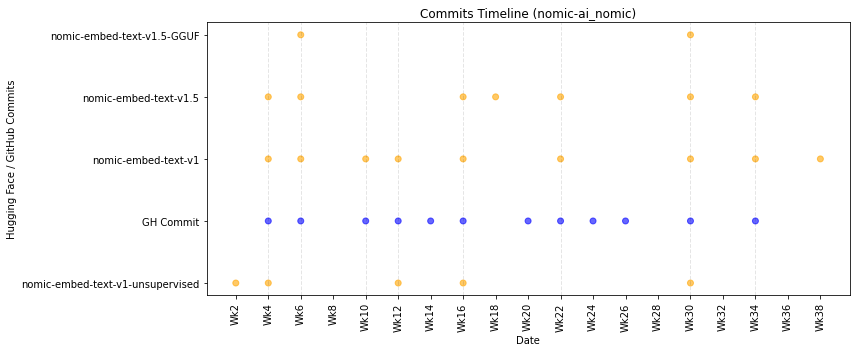

In [3]:
# File paths
file1 = "reduced_columns_GH_commit.csv"
file2 = "HF_commit_986.csv"
file3 = "manually_sampled_result.csv"

# Reading CSV files with latin1 encoding
GH_commit1 = pd.read_csv(file1, encoding='latin1')
HF_commit1 = pd.read_csv(file2, encoding='latin1')
families = pd.read_csv(file3, encoding='latin1')

GH_commit1 = GH_commit1[['owner', 'model_name', 'commit_date', 'family']]
HF_commit1 = HF_commit1[['owner', 'model_name', 'created_at', 'last_updated', 'date', 'family']]

family = list(families['family'].unique())
print(family)


def get_right_part(name):
    return name.split('/')[-1] if isinstance(name, str) else name


owners = ['nomic-ai_nomic']


def filter_data_by_owner(owner, GH_commit1, HF_commit1):
    GH_commit = GH_commit1[GH_commit1["family"] == owner].copy()
    HF_commit = HF_commit1[HF_commit1['family'] == owner].copy()

    # Convert to datetime and handle missing values
    GH_commit['commit_date'] = pd.to_datetime(GH_commit['commit_date'], errors='coerce').dt.tz_localize(None)
    HF_commit['date'] = pd.to_datetime(HF_commit['date'], format='%m/%d/%Y', errors='coerce').dt.tz_localize(None)

    # Apply the function to HuggingFace data
    HF_commit['model_name'] = HF_commit['model_name'].apply(get_right_part)

    # For GitHub activities, add fixed labels
    GH_commit['model_name'] = 'GH Commit'

    # Combine the data
    commit_data = pd.concat([HF_commit[['date', 'model_name']],
                             GH_commit[['commit_date', 'model_name']].rename(columns={'commit_date': 'date'})],
                            ignore_index=True)
    return commit_data


# Function to set biweekly ticks
def set_biweekly_ticks(ax, data):
    start_date = data['date'].min()
    end_date = data['date'].max()
    num_biweeks = (end_date - start_date).days // 14 + 1
    ticks = [start_date + timedelta(days=i * 14) for i in range(num_biweeks)]
    ax.set_xticks(ticks)

    # Add dashed lines for each biweek only if both GH commit and variant commit exist in that biweek
    for tick in ticks:
        # Check if there are both GH commits and variant commits in the current biweek
        gh_commit_in_biweek = not data[(data['date'] >= tick) & (data['date'] < tick + timedelta(days=14)) & (
                    data['model_name'] == 'GH Commit')].empty
        variant_commit_in_biweek = not data[(data['date'] >= tick) & (data['date'] < tick + timedelta(days=14)) & (
                    data['model_name'] != 'GH Commit')].empty

        # Only add a dashed line if both types of commits exist in the biweek
        if gh_commit_in_biweek and variant_commit_in_biweek:
            ax.axvline(x=tick, color='black', linestyle='--', alpha=0.1, linewidth=1)  # Longer and lighter dashed lines

    week_labels = [f'Wk{i * 2 + 2}' for i in range(len(ticks))]  # Start from Week 2
    ax.set_xticklabels(week_labels, rotation=90)


# Function to plot the activity for each owner
def plot_activity(ax, data, title, y_label):
    data = data.dropna(subset=['date'])  # Ensure there are no missing date values
    if not data.empty:
        # Create custom biweekly periods
        min_date = data['date'].min()
        data['biweek'] = (data['date'] - min_date).dt.days // 14

        # Group data by biweek and model_name
        grouped_data = data.groupby(['biweek', 'model_name']).first().reset_index()

        # Calculate the start date for each biweek
        grouped_data['biweek_start'] = min_date + pd.to_timedelta(grouped_data['biweek'] * 14, unit='D')

        colors = grouped_data['model_name'].apply(lambda x: 'blue' if x == 'GH Commit' else 'orange')
        ax.scatter(grouped_data['biweek_start'], grouped_data['model_name'], color=colors, alpha=0.6)
        ax.set_title(title)
        ax.set_ylabel(y_label)
        set_biweekly_ticks(ax, data)  # Set the ticks and dashed lines only where needed
    else:
        ax.set_title(title)
        ax.set_ylabel(y_label)
        ax.set_xticks([])  # Remove x-ticks for empty plots


# Plot for each owner
for owner in owners:
    commit_data = filter_data_by_owner(owner, GH_commit1, HF_commit1)

    fig, ax = plt.subplots(figsize=(12, 5))  # Create one plot per owner with one row
    plot_activity(ax, commit_data, f'Commits Timeline ({owner})', 'Hugging Face / GitHub Commits')

    ax.set_xlabel('Date')  # Set x-axis label

    plt.tight_layout()

    # Save the figure
    #save_path = f"I:/Paper2/PAPER2_experiment_steps/NLP/Experiment_for_top_models/all_dataset/sampled_families/manual_label_analysis/all_figures/{owner}_commits_timeline.png"
    #plt.savefig('pattern_naming_example.png')  # Save each figure with the owner's name
    plt.show()

In [4]:
len(family)

181

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import numpy as np


def check_activity_lead(commit_data):
    # Drop rows with missing dates
    commit_data = commit_data.dropna(subset=['date'])

    if commit_data.empty:
        return "No Data"

    # Calculate biweekly periods
    min_date = commit_data['date'].min()
    commit_data['biweek'] = ((commit_data['date'] - min_date).dt.days // 14 + 1)  # Periods are 2, 4, 6, etc.

    # Pivot table to see activities for each period and source
    pivot = commit_data.pivot_table(index='biweek', columns='model_name', values='date', aggfunc='first').notna()

    # Iterate through periods in ascending order
    for biweek in sorted(pivot.index):
        gh_activity = pivot.at[biweek, 'GH Commit'] if 'GH Commit' in pivot.columns else False
        variant_activity = pivot.drop('GH Commit', axis=1, errors='ignore').any(axis=1).loc[biweek]

        if gh_activity and variant_activity:
            return "Simultaneous"  # Both have activity in the same biweek
        elif gh_activity and not variant_activity:
            return "GitHub First"  # GitHub has activity but variant does not
        elif variant_activity and not gh_activity:
            return "Hugging Face First"  # Variant has activity but GitHub does not

    # Default return if no clear lead is found
    return "No Data"


def synchronization(commit_data):
    # Drop rows with missing dates
    commit_data = commit_data.dropna(subset=['date'])

    if commit_data.empty:
        return "No Data"

    # Calculate biweekly periods
    min_date = commit_data['date'].min()
    commit_data['biweek'] = ((commit_data['date'] - min_date).dt.days // 14)

    # Separate GitHub and Variant activities
    github_periods = commit_data.loc[commit_data['model_name'] == 'GH Commit', 'biweek'].unique()
    variants = commit_data.loc[commit_data['model_name'] != 'GH Commit', 'model_name'].unique()

    # Check for complete overlap (CS)
    all_variants_overlap = True
    for variant in variants:
        variant_periods = commit_data.loc[commit_data['model_name'] == variant, 'biweek'].unique()
        if not set(variant_periods).issubset(github_periods):
            all_variants_overlap = False
            break

    if all_variants_overlap:
        return "CS"

    # Check for partial overlap (PS)
    variant_periods = commit_data.loc[commit_data['model_name'] != 'GH Commit', 'biweek'].unique()
    overlap_periods = set(variant_periods).intersection(github_periods)
    if overlap_periods:
        return "PS"

    # Check for variant dominance (VS)
    variant_counts_by_period = (
        commit_data[commit_data['model_name'] != 'GH Commit']
        .groupby('biweek')['model_name']
        .nunique()
    )  # Count unique variants in each period

    # Identify periods with at least 3 unique variants
    periods_with_three_or_more_variants = variant_counts_by_period[variant_counts_by_period >= 3]

    # If there are at least 3 such periods, return "VS"
    if len(periods_with_three_or_more_variants) >= 3:
        return "VS"

    # Default case (AS)
    return "AS"


def intensity(commit_data):
    # Drop rows with missing dates
    commit_data = commit_data.dropna(subset=['date'])

    if commit_data.empty:
        return "No Data"

    # Calculate biweekly periods
    min_date = commit_data['date'].min()
    commit_data['biweek'] = ((commit_data['date'] - min_date).dt.days // 14)

    # Separate GitHub and Variant activities
    github_periods = commit_data.loc[commit_data['model_name'] == 'GH Commit', 'biweek'].unique()
    variants = commit_data.loc[commit_data['model_name'] != 'GH Commit', 'model_name'].unique()

    # Ensure every variant's activity spans <=3 biweekly periods
    for variant in variants:
        variant_periods = commit_data[commit_data['model_name'] == variant]['biweek'].unique()
        print(variant_periods)
        if len(variant_periods) > 3:
            break  # If any variant exceeds the threshold, skip "R" condition
    else:
        # Only executed if all variants satisfy the condition
        return "R"

    # Check if there are 5 consecutive overlapping periods
    for variant in variants:
        # Get the periods for the current variant
        variant_periods = commit_data[commit_data['model_name'] == variant]['biweek'].unique()

        # Get the overlapping periods between the variant and GitHub
        overlap_periods = sorted(set(variant_periods).intersection(github_periods))

        # If no overlap exists, continue to the next variant
        if not overlap_periods:
            continue

        # Check for 5 consecutive overlaps (with no gaps in between)
        consecutive_count = 1  # Initialize count of consecutive periods
        last_overlap = overlap_periods[0]  # Start with the first overlap period

        for i in range(1, len(overlap_periods)):
            current_overlap = overlap_periods[i]

            # Check if the current overlap is exactly 1 biweek after the previous overlap
            if current_overlap == last_overlap + 1:
                consecutive_count += 1
            else:
                consecutive_count = 1  # Reset if there is a gap

            # If 5 consecutive periods are found, return "F"
            if consecutive_count >= 5:
                return "F"

            last_overlap = current_overlap  # Update the last_overlap to the current one

    # If no 5 consecutive overlaps, return "S"
    return "S"

In [6]:
#from functions_for_detection import *
import warnings
warnings.simplefilter("ignore", category=UserWarning)
from sklearn.metrics import cohen_kappa_score

# File paths
file1 = "reduced_columns_GH_commit.csv"
file2 = "HF_commit_986.csv"
file3 = "unique_sample_families.csv"


# Reading CSV files with latin1 encoding
GH_commit1 = pd.read_csv(file1, encoding='latin1')
HF_commit1 = pd.read_csv(file2, encoding='latin1')

families = pd.read_csv(file3, encoding='latin1')

GH_commit1 = GH_commit1[['owner', 'github', 'model_name', 'commit_date', 'family']]
HF_commit1 = HF_commit1[['owner', 'model_name', 'created_at', 'last_updated', 'date', 'family']]

def get_right_part(name):
    return name.split('/')[-1] if isinstance(name, str) else name

sampled_families = families['family'].unique()



remaining_GH = GH_commit1[GH_commit1['family'].isin(sampled_families)]
remaining_HF = HF_commit1[HF_commit1['family'].isin(sampled_families)]

def filter_data_by_owner(owner, GH_commit1, HF_commit1):
    GH_commit = remaining_GH[remaining_GH["family"] == owner].copy()
    HF_commit = remaining_HF[remaining_HF['family'] == owner].copy()

    # Convert to datetime and handle missing values
    GH_commit['commit_date'] = pd.to_datetime(GH_commit['commit_date'], errors='coerce').dt.tz_localize(None)
    HF_commit['date'] = pd.to_datetime(HF_commit['date'], format='%m/%d/%Y', errors='coerce').dt.tz_localize(None)

    # Apply the function to HuggingFace data
    HF_commit['model_name'] = HF_commit['model_name'].apply(get_right_part)

    # For GitHub activities, add fixed labels
    GH_commit['model_name'] = 'GH Commit'

    # Combine the data
    commit_data = pd.concat([HF_commit[['date', 'model_name']],
                             GH_commit[['commit_date', 'model_name']].rename(columns={'commit_date': 'date'})],
                            ignore_index=True)
    return commit_data

owners = list(remaining_HF['family'].unique())[50:55]


owner_sampled = sampled_families


family = []
lag = []
sync = []
asynchronous = []
intensities = []



for owner in owners:
    commit_data = filter_data_by_owner(owner, remaining_GH, remaining_HF)
    lagged = check_activity_lead(commit_data)
    syncs = synchronization(commit_data)
    intenses = intensity(commit_data)

    family.append(owner)
    lag.append(lagged)
    sync.append(syncs)
    intensities.append(intenses)

    #print(commit_overlap)

output_data = pd.DataFrame({'family': family,
                            'Lagged': lag,
                            'Syncs': sync,
                            'intensity': intensities
})#.reset_index()

# Save to CSV
#output_data.to_csv('I:/Paper2/PAPER2_experiment_steps/NLP/Experiment_for_top_models/all_dataset/sampled_families/results/confirmations.csv', index=None)

#print("Data has been successfully saved to 'family_horizontal_data.csv'.")
print(output_data)



[15 13 11]
[5]
[40  0]
[72 60 54 42 41 34 27 20 18 17 16 13  8]
[187 183 154 149 114  93  91  88  85]
                       family              Lagged Syncs intensity
0      EmergentMethods_gliner        GitHub First    PS         R
1                emrecan_bert        GitHub First    CS         R
2  eugenesiow_bart-paraphrase  Hugging Face First    AS         R
3               facebook_bart  Hugging Face First    VS         S
4         facebook_blenderbot        GitHub First    PS         S


In [7]:
file1 = "../RQ1/complete_dataset.csv"
file2 = "../RQ1/must_exclude_from_all_analysis.csv"


dataset = pd.read_csv(file1, encoding='latin1')
exclude = pd.read_csv(file2, encoding='latin1')

exclusion = list(exclude['family'].unique())


df = dataset[~dataset['family'].isin(exclusion)]
df

,owner,model_name,family,downloads,likes,created_at_main,last_modified_main,age,adoption,library_name,...,codes,Lagged,pattern_names,names,first_created,last_modified,first_commits,last_commits,age_days_individual_x,average_age_days
0,google-bert,google-bert/bert-base-uncased,google-bert_bert,67352152,1618,3/2/2022,2/19/2024,903,74587.100780,transformers,...,PSS,Upstream First,Dispersed Alignment Pattern,Dispersed Alignment,2022-03-02 23:29:04+00:00,2024-02-19 11:06:12+00:00,2018-11-14 23:35:08+00:00,2024-02-19 11:06:12+00:00,1922,1811.230769
1,facebook,facebook/fasttext-language-identification,facebook_fasttext,52552566,120,4/6/2022,1/24/2023,868,60544.430880,fasttext,...,PSR,Upstream First,Sparse Alignment Pattern,Sparse Alignment,2023-03-06 12:52:50+00:00,2023-06-09 12:39:43+00:00,2023-03-06 12:52:50+00:00,2023-06-09 12:39:43+00:00,94,94.000000
2,distilbert,distilbert/distilbert-base-uncased,distilbert_distilbert,30382216,444,3/2/2022,12/19/2023,903,33645.864890,transformers,...,CSS,Upstream First,Intermittent Alignment Pattern,Intermittent Alignment,2022-03-02 23:29:04+00:00,2024-05-06 13:44:53+00:00,2019-08-28 12:31:11+00:00,2024-05-06 13:44:53+00:00,1713,1603.000000
7,cardiffnlp,cardiffnlp/twitter-roberta-base-sentiment-latest,cardiffnlp_tweeteval,11244103,452,8/2/2022,1/10/2023,750,14992.137330,transformers,...,PSS,Upstream First,Dispersed Alignment Pattern,Dispersed Alignment,2022-03-15 01:21:58+00:00,2023-05-28 05:45:10+00:00,2022-03-15 01:21:58+00:00,2023-05-28 05:45:10+00:00,439,628.200000
8,nomic-ai,nomic-ai/nomic-embed-text-v1.5,nomic-ai_nomic,10974960,237,2/10/2024,8/1/2024,193,56865.077720,sentence-transformers,...,PSS,Downstream First,Dispersed Alignment Pattern,Dispersed Alignment,2024-02-10 06:32:35+00:00,2024-11-18 20:39:44+00:00,2024-02-10 06:32:35+00:00,2024-11-18 20:39:44+00:00,282,221.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,jinaai,jinaai/jina-embeddings-v2-base-es,jinaai_jina,10135,17,1/24/2024,8/6/2024,210,48.261905,sentence-transformers,...,ASS,Upstream First,Sporadic Disjoint Pattern,Sporadic Disjoint,2024-01-24 09:54:03+00:00,2024-08-06 14:41:45+00:00,2024-01-24 09:54:03+00:00,2024-08-06 14:41:45+00:00,195,203.285714
982,bigscience,bigscience/mt0-base,bigscience_workshop,10125,25,8/7/2022,2/10/2023,745,13.590604,transformers,...,PSF,Upstream First,Dense Partial Alignment Pattern,Dense Partial Alignment,2022-10-27 19:21:27+00:00,2023-09-26 09:17:05+00:00,2022-10-27 19:21:27+00:00,2023-09-26 09:17:05+00:00,333,436.000000
983,MoritzLaurer,MoritzLaurer/deberta-v3-large-zeroshot-v1,MoritzLaurer_DeBERTa,10123,19,9/29/2023,11/29/2023,327,30.957187,transformers,...,PSS,Downstream First,Dispersed Alignment Pattern,Dispersed Alignment,2023-10-03 03:24:13+00:00,2023-11-29 19:30:53+00:00,2023-10-03 03:24:13+00:00,2023-11-29 19:30:53+00:00,57,492.500000
984,shhossain,shhossain/opus-mt-en-to-bn,shhossain_opus-mt,10045,2,8/21/2023,8/23/2023,366,27.445355,transformers,...,PSR,No Lag,Sparse Alignment Pattern,Sparse Alignment,2023-08-26 12:17:37+00:00,2024-02-03 18:52:29+00:00,2023-08-26 12:17:37+00:00,2024-02-03 18:52:29+00:00,161,161.000000


In [8]:
import pandas as pd
from scipy.stats import chi2_contingency
import ast

# Load the datasets
file1 = "../RQ1/GH_labelled_with_patterns.csv"
file2 = "../RQ1/HF_labelled_with_patterns_authors.csv"
f2 = "../RQ1/must_exclude_from_all_analysis.csv"

df_gh = pd.read_csv(file1, encoding='latin1')
df_hf = pd.read_csv(file2, encoding='latin1')
dfs2 = pd.read_csv(f2, encoding='latin1')

HF1 = df_hf[df_hf['author_HF'] != "No_GH"]

exclusion = list(dfs2['family'].unique())

GH = df_gh[~df_gh['family'].isin(exclusion)]
HF = HF1[~HF1['family'].isin(exclusion)]

gh = GH.groupby("family").agg({
    'author_GH': 'unique'
}).reset_index()

hf = HF.groupby("family").agg({
    'author_HF': 'unique'
}).reset_index()

def string_to_list(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except (SyntaxError, ValueError):
            return []
    return x

# Apply the function to ensure that the author columns contains list
gh['author_GH'] = gh['author_GH'].apply(string_to_list)
hf['author_HF'] = hf['author_HF'].apply(string_to_list)

merged = pd.merge(hf, gh,  on="family", how="inner")

# Extract three families, their authors, and common authors
sample_families = merged  # Select the first three families
family_data = []

for _, row in sample_families.iterrows():
    family_name = row['family']
    authors_gh = set(row['author_GH'])  # Convert to set for comparison
    authors_hf = set(row['author_HF'])
    common_authors = list(authors_hf.intersection(authors_gh))  # Find common authors

    family_data.append({
        "family": family_name,
        "authors_GH": list(authors_gh),
        "authors_HF": list(authors_hf),
        "common_authors": common_authors
    })

# Convert to a DataFrame for easy display
result_df = pd.DataFrame(family_data)
result_df['common_authors_count'] = result_df['common_authors'].apply(len)
#result_df['total'] = lambda x: x in result_df['common_authors']

# Print results
print("\nSample Families with Authors from GH and HF and Their Common Authors:")
result_df

# Optionally, save results to CSV
#result_df.to_json("I:/Paper2/PAPER2_experiment_steps/NLP/Experiment_for_top_models/all_dataset/sampled_families/results/RQ_datas/RQ3_dataset/family_author_comparison.json", index=False)


#print(gh)
#print(hf)





Sample Families with Authors from GH and HF and Their Common Authors:


,family,authors_GH,authors_HF,common_authors,common_authors_count
0,01-ai_YI,"[https://github.com/richardllin, https://githu...","[https://github.com/findmyway, https://github....","[https://github.com/ZhaoFancy, https://github....",4
1,1-800-BAD-CODE_XLM-ROBERTA,"[https://github.com/Unknown, https://github.co...",[https://github.com/1-800-BAD-CODE],[https://github.com/1-800-BAD-CODE],1
2,42dot_42DOT-LLM,"[https://github.com/likejazz, https://github.c...",[https://github.com/wangcho2k],[],0
3,AnnaWegmann_Style-Embedding,"[https://github.com/AnnaWegmann, https://githu...",[https://github.com/AnnaWegmann],[https://github.com/AnnaWegmann],1
4,BAAI_bge,"[https://github.com/ycjcl868, https://github.c...","[https://github.com/zacliu2023, https://github...","[https://github.com/ftgreat, https://github.co...",2
...,...,...,...,...,...
301,wukevin_tcr-bert,"[https://github.com/swansonk14, https://github...",[https://github.com/wukevin],[https://github.com/wukevin],1
302,wxjiao_alpaca,[https://github.com/wxjiao],[https://github.com/wxjiao],[https://github.com/wxjiao],1
303,xlnet_xlnet,"[https://github.com/zihangdai, https://github....","[https://github.com/julien-c, https://github.c...",[],0
304,yahma_llama,"[https://github.com/lmarcon, https://github.co...",[https://github.com/gururise],[],0


<ipython-input-53-43821a552e8d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['names'] = df['names'].replace(name_mapping)


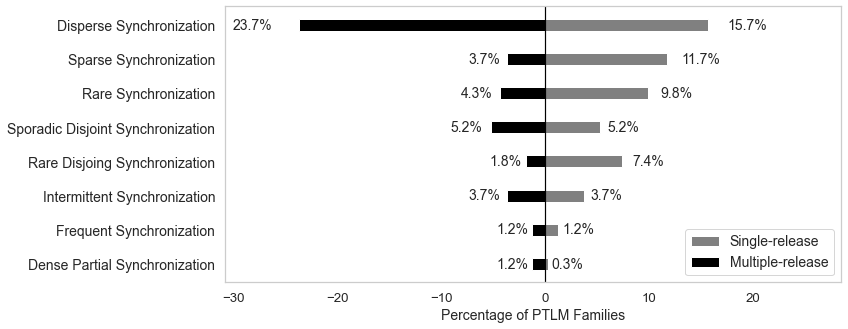

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

file1 = "../RQ1/complete_dataset.csv"
file2 = "../RQ1/must_exclude_from_all_analysis.csv"

# Load data
dataset = pd.read_csv(file1, encoding='latin1')
exclude = pd.read_csv(file2, encoding='latin1')

# Filter out excluded families
exclusion = list(exclude['family'].unique())
df = dataset[~dataset['family'].isin(exclusion)]

# Rename coordination patterns
name_mapping = {
    'Dense Partial Alignment': 'Dense Partial Synchronization',
    'Frequent Alignment': 'Frequent Synchronization',
    'Intermittent Alignment': 'Intermittent Synchronization',
    'Rare Alignment': 'Rare Synchronization',
    'Sparse Alignment': 'Sparse Synchronization',
    'Dispersed Alignment': 'Disperse Synchronization',
    'Sporadic Disjoint': 'Sporadic Disjoint Synchronization',
    'Rare Disjoing': 'Rare Disjoing Synchronization'
}

df['names'] = df['names'].replace(name_mapping)

# Group and classify
grouping = df.groupby(['family', 'names'])['model_name'].nunique().reset_index(name='model_name_count')
grouping['release_type'] = grouping['model_name_count'].apply(lambda x: 'Single-release' if x == 1 else 'Multiple-release')

# Count per coordination pattern
release_counts = grouping.groupby('names')['release_type'].value_counts().unstack(fill_value=0)

# Convert to global percentages
total = release_counts.to_numpy().sum()
release_percentages = (release_counts / total) * 100

# Sort by total counts
sorted_names = release_counts.sum(axis=1).sort_values(ascending=True).index.tolist()

# Plotting
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(12, len(sorted_names) * 0.6))

x = np.arange(len(sorted_names))
width = 0.35

# Bidirectional bars
rects1 = ax.barh(x, release_percentages.loc[sorted_names, 'Single-release'], width, label='Single-release', color='gray')
rects2 = ax.barh(x, -release_percentages.loc[sorted_names, 'Multiple-release'], width, label='Multiple-release', color='black')

# Customize chart
ax.set_xlabel('Percentage of PTLM Families', fontsize=14)
ax.set_yticks(x)
ax.set_yticklabels(sorted_names, fontsize=14)
ax.axvline(0, color='black', linewidth=1.2)
ax.legend(fontsize=14, loc='lower right')
#ax.set_title('Upstream                                                      Downstream', fontsize=16)

# Add labels
def autolabel_bidirectional(rects, is_negative=False):
    for rect in rects:
        width = rect.get_width()
        if is_negative:
            label_x = width - 3
            ha = 'right'
        else:
            label_x = width + 3
            ha = 'left'
        ax.annotate(f'{abs(width):.1f}%',
                    xy=(width, rect.get_y() + rect.get_height()/2),
                    xytext=(label_x, 0),
                    textcoords="offset points",
                    ha=ha, va='center',
                    fontsize=14)

autolabel_bidirectional(rects1, is_negative=False)
autolabel_bidirectional(rects2, is_negative=True)

# Set symmetrical x-axis
x_max = max(release_percentages['Single-release'].max(), release_percentages['Multiple-release'].max())
ax.set_xlim(-x_max * 1.3, x_max * 1.2)
ax.grid(False)

plt.tight_layout()
plt.savefig("argument3_1.pdf", bbox_inches='tight')
plt.show()

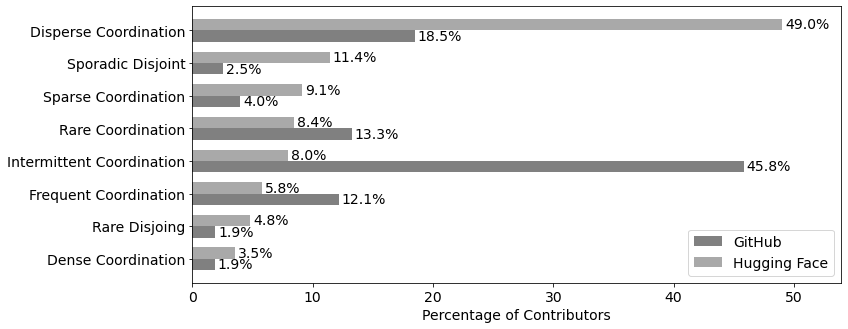

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file1 = "../RQ1/GH_labelled_with_patterns.csv"
file2 = "../RQ1/HF_labelled_with_patterns_authors.csv"
f2 = "../RQ1/must_exclude_from_all_analysis.csv"

gh = pd.read_csv(file1, encoding='latin1')
hf = pd.read_csv(file2, encoding='latin1')
exclude = pd.read_csv(f2, encoding='latin1')

exclusion = list(exclude['family'].unique())

GH1 = gh[~gh['family'].isin(exclusion)]
HF1 = hf[~hf['family'].isin(exclusion)]

group_gh = GH1.groupby(["owner", "family"]).agg({
    'author_username': "nunique"
}).reset_index()

GH = pd.merge(group_gh, grouping, on='family', how='inner')

group_hf = HF1.groupby(["owner", "family"]).agg({
    'author': "nunique"
}).reset_index()

HF = pd.merge(group_hf, grouping, on='family', how='inner')

gh_authors = GH.groupby('names')['author_username'].sum().reset_index()
hf_authors = HF.groupby('names')['author'].sum().reset_index()

# Calculate percentages for each platform separately
gh_authors['gh_percentage'] = gh_authors['author_username'] / gh_authors['author_username'].sum() * 100
hf_authors['hf_percentage'] = hf_authors['author'] / hf_authors['author'].sum() * 100

# Merge the data
merged_data = pd.merge(gh_authors[['names', 'gh_percentage']], hf_authors[['names', 'hf_percentage']], on='names')

# Sort by GitHub percentage
merged_data = merged_data.sort_values('hf_percentage', ascending=True)

# Increase font size to 14
plt.rcParams.update({'font.size': 14})

# Create the plot
fig, ax = plt.subplots(figsize=(12, len(merged_data) * 0.6))

x = np.arange(len(merged_data['names']))
width = 0.35

# Plot bars
rects1 = ax.barh(x - width/2, merged_data['gh_percentage'], width, label='GitHub', color='gray')
rects2 = ax.barh(x + width/2, merged_data['hf_percentage'], width, label='Hugging Face', color='darkgray')

# Customize the chart
ax.set_xlabel('Percentage of Contributors', fontsize=14)
ax.set_yticks(x)
ax.set_yticklabels(merged_data['names'], fontsize=14)
ax.legend(fontsize=14)

# Add percentage labels on top of the bars
def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        ax.annotate(f'{width:.1f}%',
                    xy=(width, rect.get_y() + rect.get_height()/2),
                    xytext=(3, 0),  # 3 points horizontal offset
                    textcoords="offset points",
                    ha='left', va='center',
                    fontsize=14)

autolabel(rects1)
autolabel(rects2)

# Set x-axis limit to ensure all labels are visible
max_percentage = max(merged_data['gh_percentage'].max(), merged_data['hf_percentage'].max())
ax.set_xlim(0, max_percentage * 1.1)  # Add 10% extra space

# Update font sizes for specific elements
ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.savefig("argument3_2.pdf", bbox_inches='tight')
plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file1 = "../RQ1/GH_labelled_with_patterns.csv"
file2 = "../RQ1/HF_labelled_with_patterns_authors.csv"
f2 = "../RQ1/must_exclude_from_all_analysis.csv"

gh = pd.read_csv(file1, encoding='latin1')
hf = pd.read_csv(file2, encoding='latin1')
exclude = pd.read_csv(f2, encoding='latin1')

exclusion = list(exclude['family'].unique())

GH1 = gh[~gh['family'].isin(exclusion)]
HF1 = hf[~hf['family'].isin(exclusion)]

# Assuming 'grouping' is defined elsewhere in your context
group_gh = GH1.groupby(["owner", "family"]).agg({
    'author_username': "nunique"
}).reset_index()
GH = pd.merge(group_gh, grouping, on='family', how='inner')

group_hf = HF1.groupby(["owner", "family"]).agg({
    'author': "nunique"
}).reset_index()
HF = pd.merge(group_hf, grouping, on='family', how='inner')


gh_authors = GH.groupby('names')['author_username'].sum().reset_index()
hf_authors = HF.groupby('names')['author'].sum().reset_index()

# Percentages
gh_authors['gh_percentage'] = gh_authors['author_username'] / gh_authors['author_username'].sum() * 100
hf_authors['hf_percentage'] = hf_authors['author'] / hf_authors['author'].sum() * 100

# Merge
merged_data = pd.merge(gh_authors[['names', 'gh_percentage']], hf_authors[['names', 'hf_percentage']], on='names')

gh_authors = GH.groupby(['names', 'family'])['author_username'].sum().reset_index()
hf_authors = HF.groupby(['names', 'family'])['author'].sum().reset_index()

hf_authors


,names,family,author
0,Dense Coordination,JackFram_llama,1
1,Dense Coordination,Qwen_Qwen,3
2,Dense Coordination,bigscience_workshop,19
3,Dense Coordination,mistralai_Mistral-inference,12
4,Dense Coordination,mosaicml_mpt,6
...,...,...,...
320,Sporadic Disjoint,nbroad_ESG-BERT,2
321,Sporadic Disjoint,nlpaueb_legal-bert,4
322,Sporadic Disjoint,openai-community_openai,5
323,Sporadic Disjoint,rinna_japanese-gpt,4


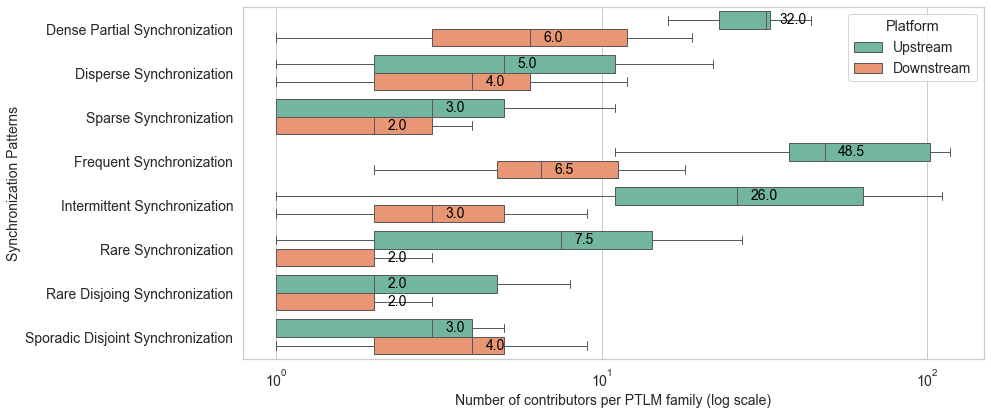

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
file1 = "../RQ1/GH_labelled_with_patterns.csv"
file2 = "../RQ1/HF_labelled_with_patterns_authors.csv"
f2 = "../RQ1/must_exclude_from_all_analysis.csv"

gh = pd.read_csv(file1, encoding='latin1')
hf = pd.read_csv(file2, encoding='latin1')
exclude = pd.read_csv(f2, encoding='latin1')

exclusion = list(exclude['family'].unique())

GH1 = gh[~gh['family'].isin(exclusion)]
HF1 = hf[~hf['family'].isin(exclusion)]

# Merge in groupings
group_gh = GH1.groupby(["owner", "family", "patterns"]).agg({
    'author_username': "nunique"
}).reset_index()
GH = pd.merge(group_gh, grouping, on='family', how='inner')

group_hf = HF1.groupby(["owner", "family", "patterns"]).agg({
    'author': "nunique"
}).reset_index()
HF = pd.merge(group_hf, grouping, on='family', how='inner')

# Create contributor counts per model family under each name
gh_authors = GH.groupby(['names', 'family', 'patterns'])['author_username'].sum().reset_index()
hf_authors = HF.groupby(['names', 'family', 'patterns'])['author'].sum().reset_index()

name_mapping = {
    'Dense Partial Alignment Pattern': 'Dense Partial Synchronization',
    'Frequent Alignment Pattern': 'Frequent Synchronization',
    'Intermittent Alignment Pattern': 'Intermittent Synchronization',
    'Rare Alignment Pattern': 'Rare Synchronization',
    'Sparse Alignment Pattern': 'Sparse Synchronization',
    'Dispersed Alignment Pattern': 'Disperse Synchronization',
    'Sporadic Disjoint Pattern': 'Sporadic Disjoint Synchronization',
    'Rare disjoint pattern': 'Rare Disjoing Synchronization'
}

gh_authors['patterns'] = gh_authors['patterns'].replace(name_mapping)
hf_authors['patterns'] = hf_authors['patterns'].replace(name_mapping)

# Add a column to identify the source
gh_authors['platform'] = 'GitHub'
hf_authors['platform'] = 'Hugging Face'

# Rename columns to unify them
gh_authors.rename(columns={'author_username': 'num_authors'}, inplace=True)
hf_authors.rename(columns={'author': 'num_authors'}, inplace=True)

# Combine both datasets
combined = pd.concat([gh_authors, hf_authors], axis=0)

# Rename platform labels
combined['platform'] = combined['platform'].map({
    'GitHub': 'Upstream',
    'Hugging Face': 'Downstream'
})

# Set plot style
sns.set(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(14, 6))

# Create the boxplot without showing outliers and with horizontal orientation
ax = sns.boxplot(
    data=combined,
    x='num_authors',
    y='patterns',
    hue='platform',
    palette='Set2',
    orient='h',
    showfliers=False
)

# Set x-axis to log scale
plt.xscale('log')

# Annotate medians
grouped = combined.groupby(['patterns', 'platform'])['num_authors']
medians = grouped.median().reset_index()

# Annotate each median
for i, row in medians.iterrows():
    pattern = row['patterns']
    platform = row['platform']
    median_val = row['num_authors']

    # Get y-position of pattern
    y_pos = list(combined['patterns'].unique()).index(pattern)
    if platform == 'Upstream':
        y_pos = y_pos - 0.2
    else:
        y_pos = y_pos + 0.2

    plt.text(
        x=median_val * 1.1,  # Shift right slightly for log scale
        y=y_pos,
        s=f'{median_val:.1f}',
        color='black',
        va='center',
        ha='left',
        fontsize=14
    )



plt.ylabel("Synchronization Patterns", fontsize=14)
plt.xlabel("Number of contributors per PTLM family (log scale)", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(title="Platform", fontsize=14)
#plt.title("Contributor Distribution per Model Category (GitHub vs Hugging Face)", fontsize=16)

plt.tight_layout()
plt.savefig("argument3_2.pdf", bbox_inches='tight')
plt.show()



In [13]:
combined

,names,family,patterns,num_authors,platform
0,Dense Coordination,JackFram_llama,Dense Partial Coordination,44,Upstream
1,Dense Coordination,Qwen_Qwen,Dense Partial Coordination,32,Upstream
2,Dense Coordination,bigscience_workshop,Dense Partial Coordination,16,Upstream
3,Dense Coordination,mistralai_Mistral-inference,Dense Partial Coordination,23,Upstream
4,Dense Coordination,mosaicml_mpt,Dense Partial Coordination,33,Upstream
...,...,...,...,...,...
320,Sporadic Disjoint,nbroad_ESG-BERT,Sporadic Disjoint Pattern,2,Downstream
321,Sporadic Disjoint,nlpaueb_legal-bert,Sporadic Disjoint Pattern,4,Downstream
322,Sporadic Disjoint,openai-community_openai,Sporadic Disjoint Pattern,5,Downstream
323,Sporadic Disjoint,rinna_japanese-gpt,Sporadic Disjoint Pattern,4,Downstream


Chi-square statistic: 1321.663716814159
P-value: 3.425036874877538e-281
The synchronization patterns are statistically different (reject the null hypothesis).


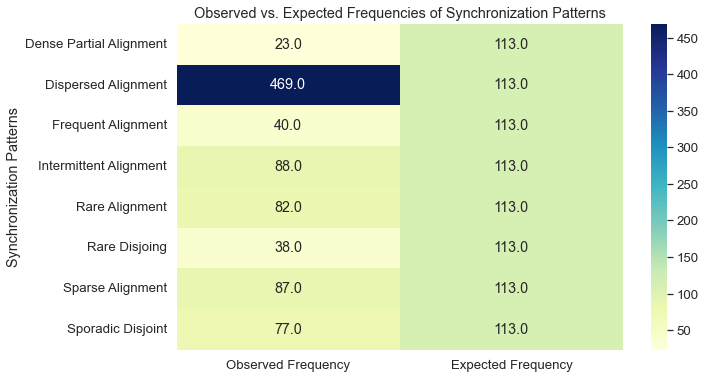

In [14]:
import pandas as pd
from scipy.stats import chisquare
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data
file1 = "../RQ1/complete_dataset.csv"  
f2 = "../RQ1/must_exclude_from_all_analysis.csv"

df1 = pd.read_csv(file1, encoding='latin1')
exclude = pd.read_csv(f2, encoding='latin1')

exclusion = list(exclude['family'].unique())

df = df1[~df1['family'].isin(exclusion)]

pattern_name = df['names']

# Calculate observed frequencies
observed_frequencies = pattern_name.value_counts().sort_index()

# Calculate expected frequencies (uniform distribution)
expected_frequency = len(pattern_name) / len(observed_frequencies)
expected_frequencies = np.full(len(observed_frequencies), expected_frequency)

# Perform chi-square goodness-of-fit test
chi2, p = chisquare(observed_frequencies, expected_frequencies)

# Print the results
print("Chi-square statistic:", chi2)
print("P-value:", p)

# Interpret the results
alpha = 0.05  # Significance level

if p < alpha:
    print("The synchronization patterns are statistically different (reject the null hypothesis).")
else:
    print("The synchronization patterns are not statistically different (fail to reject the null hypothesis).")

# Visualize observed and expected frequencies using a heatmap
observed_df = pd.DataFrame({'Pattern': observed_frequencies.index, 'Observed Frequency': observed_frequencies.values})
expected_df = pd.DataFrame({'Pattern': observed_frequencies.index, 'Expected Frequency': expected_frequencies})

merged_df = pd.merge(observed_df, expected_df, on='Pattern')
merged_df = merged_df.set_index('Pattern')

plt.figure(figsize=(10, 6))
sns.heatmap(merged_df, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Observed vs. Expected Frequencies of Synchronization Patterns")
plt.ylabel("Synchronization Patterns")
plt.show()

# Replication Package:
# The python script that was used is included in the replication package.
# (Add information on where the replication package is located, or how to access it.)

In [15]:
print(merged_df.reset_index())

                   Pattern  Observed Frequency  Expected Frequency
0  Dense Partial Alignment                  23               113.0
1      Dispersed Alignment                 469               113.0
2       Frequent Alignment                  40               113.0
3   Intermittent Alignment                  88               113.0
4           Rare Alignment                  82               113.0
5            Rare Disjoing                  38               113.0
6         Sparse Alignment                  87               113.0
7        Sporadic Disjoint                  77               113.0


In [16]:
import pandas as pd
import ast
from scipy.stats import chi2_contingency

# Load the datasets
file1 = "../RQ1/GH_labelled_with_patterns.csv"
file2 = "../RQ1/HF_labelled_with_patterns_authors.csv"
f2 = "../RQ1/must_exclude_from_all_analysis.csv"

df_gh = pd.read_csv(file1, encoding='latin1')
df_hf = pd.read_csv(file2, encoding='latin1')
dfs2 = pd.read_csv(f2, encoding='latin1')

#HF1 = df_hf[df_hf['author_HF'] != "No_GH"]

# Exclude certain families
exclusion = list(dfs2['family'].unique())
GH = df_gh[~df_gh['family'].isin(exclusion)]
HF = df_hf[~df_hf['family'].isin(exclusion)]

# Group and aggregate by family and patterns
gh = GH.groupby(["family", "patterns"]).agg({
    'author_username': 'unique'
}).reset_index()

hf = HF.groupby(["family", "patterns"]).agg({
    'author': 'unique'
}).reset_index()

# Helper function to safely convert strings to lists
def string_to_list(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except (SyntaxError, ValueError):
            return []
    return x

# Apply conversion and count authors
gh['author_username'] = gh['author_username'].apply(string_to_list)
hf['author'] = hf['author'].apply(string_to_list)

gh['GH_authors_count'] = gh['author_username'].apply(len)
hf['HF_authors_count'] = hf['author'].apply(len)

# 🟡 Categorize as "single" or "multiple"
gh['GH_author_group'] = gh['GH_authors_count'].apply(lambda x: 'single' if x == 1 else 'multiple')
hf['HF_author_group'] = hf['HF_authors_count'].apply(lambda x: 'single' if x == 1 else 'multiple')

# Merge GH and HF
merged = pd.merge(hf, gh, on=["family", "patterns"], how="inner")

merged

,family,patterns,author,HF_authors_count,HF_author_group,author_username,GH_authors_count,GH_author_group
0,01-ai_YI,Frequent Alignment Pattern,"[Mia01ai, Chen-01AI, Chen Chongyu, Mia Xia, an...",18,multiple,"[Haijian06, nlmlml, Mia-xia, Unknown, Anonymit...",46,multiple
1,1-800-BAD-CODE_XLM-ROBERTA,Dispersed Alignment Pattern,[1-800-BAD-CODE],1,single,"[1-800-BAD-CODE, Unknown]",2,multiple
2,42dot_42DOT-LLM,Sparse Alignment Pattern,"[ykhwang, woojong.ryu]",2,multiple,"[blueworm7, Unknown, likejazz, shyram, skdirwj]",5,multiple
3,AnnaWegmann_Style-Embedding,Rare Alignment Pattern,[AnnaWegmann],1,single,"[AnnaWegmann, Unknown]",2,multiple
4,BAAI_bge,Frequent Alignment Pattern,"[ZacLiu, hyxmmm, shunxing1234, ldwang, Anhfort...",6,multiple,"[ZiyiXia, JUNJIE99, 545999961, ZhengLiu101, fc...",48,multiple
...,...,...,...,...,...,...,...,...
320,wukevin_tcr-bert,Sparse Alignment Pattern,"[wukevin, system]",2,multiple,"[wukevin, swansonk14]",2,multiple
321,wxjiao_alpaca,Rare Alignment Pattern,[wxjiao],1,single,[wxjiao],1,single
322,xlnet_xlnet,Dispersed Alignment Pattern,"[joaogante, nielsr, julien-c, system]",4,multiple,"[zihangdai, kimiyoung, ymcui, manrajgrover, gr...",9,multiple
323,yahma_llama,Rare disjoint pattern,[yahma],1,single,"[jspisak, samuelselvan, hyungupark, dandv, osa...",45,multiple


In [17]:
single_HF = merged[merged["HF_author_group"] == "single"]
multiple_HF = merged[merged["HF_author_group"] == "multiple"]


single_GH = merged[merged["GH_author_group"] == "single"]
multiple_GH = merged[merged["GH_author_group"] == "multiple"]

print(len(single_HF))
print(len(multiple_HF))
print(len(single_GH))
print(len(multiple_GH))


74
251
69
256


In [19]:
contingency_table_HF = pd.crosstab(merged['patterns'], merged['HF_author_group'])
chi2_HF, p_HF, dof_HF, expected = chi2_contingency(contingency_table)

contingency_table_GH = pd.crosstab(merged['patterns'], merged['GH_author_group'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Contingency Table:\n", contingency_table)
print(f"Chi-square statistic = {chi2:.3f}, p-value = {p:.3f}")

NameError: name 'contingency_table' is not defined

In [33]:
import pandas as pd
from datetime import timedelta

# File paths
file1 = "reduced_columns_GH_commit.csv"
file2 = "HF_commit_986.csv"
file3 = "../RQ1/complete_dataset.csv"
f2 = "../RQ1/must_exclude_from_all_analysis.csv"

# Read CSV files
GH_commit = pd.read_csv(file1, encoding='latin1')
HF_commit = pd.read_csv(file2, encoding='latin1')
families_df = pd.read_csv(file3, encoding='latin1')
exclude = pd.read_csv(f2, encoding='latin1')

exclusion = list(exclude['family'].unique())

GH_commit1 = GH_commit[~GH_commit['family'].isin(exclusion)]
HF_commit1 = HF_commit[~HF_commit['family'].isin(exclusion)]
fams = families_df[~families_df['family'].isin(exclusion)]


# Keep relevant columns
GH_commit1 = GH_commit1[['owner', 'model_name', 'commit_date', 'family']]
HF_commit1 = HF_commit1[['owner', 'model_name', 'created_at', 'last_updated', 'date', 'family']]

# Get list of families
families = list(fams['family'].unique())

# Helper function
def get_right_part(name):
    return name.split('/')[-1] if isinstance(name, str) else name

# Function to calculate overlapping biweekly periods for one family
def count_overlapping_biweeks(owner, GH_commit1, HF_commit1):
    gh = GH_commit1[GH_commit1["family"] == owner].copy()
    hf = HF_commit1[HF_commit1["family"] == owner].copy()

    # Convert to datetime
    gh['commit_date'] = pd.to_datetime(gh['commit_date'], errors='coerce').dt.tz_localize(None)
    hf['date'] = pd.to_datetime(hf['date'], format='%m/%d/%Y', errors='coerce').dt.tz_localize(None)

    # Format model names
    hf['model_name'] = hf['model_name'].apply(get_right_part)
    gh['model_name'] = 'GH Commit'

    # Combine and clean
    combined = pd.concat([
        hf[['date', 'model_name']],
        gh[['commit_date', 'model_name']].rename(columns={'commit_date': 'date'})
    ], ignore_index=True)

    combined = combined.dropna(subset=['date'])
    if combined.empty:
        return 0

    # Create biweekly periods
    min_date = combined['date'].min()
    combined['biweek'] = ((combined['date'] - min_date).dt.days // 14)

    # Count overlaps
    overlap_count = 0
    for biweek, group in combined.groupby('biweek'):
        models = set(group['model_name'])
        if 'GH Commit' in models and len(models) > 1:
            overlap_count += 1

    return overlap_count

# Process all families
results = []
for fam in families:
    overlap = count_overlapping_biweeks(fam, GH_commit1, HF_commit1)
    results.append({'family': fam, 'number_of_overlapping': overlap})

# Convert to DataFrame and display
overlap_df = pd.DataFrame(results)
overlap_df = overlap_df.sort_values(by = 'number_of_overlapping', ascending = False)
overlap_df


,family,number_of_overlapping
2,distilbert_distilbert,41
53,deepset_haystack,37
305,stanfordnlp_stanza,37
22,BAAI_bge,21
160,01-ai_YI,21
...,...,...
238,whaleloops_phrase-bert,0
116,Davlan_multilingual,0
270,allenai_specter2,0
215,meta-llama_CodeLlama,0


In [41]:
import pandas as pd
import ast
from scipy.stats import spearmanr

# Load the datasets
file1 = "../RQ1/GH_labelled_with_patterns.csv"
file2 = "../RQ1/HF_labelled_with_patterns_authors.csv"
f2 = "../RQ1/must_exclude_from_all_analysis.csv"

df_gh = pd.read_csv(file1, encoding='latin1')
df_hf = pd.read_csv(file2, encoding='latin1')
dfs2 = pd.read_csv(f2, encoding='latin1')

# Filter HF entries that have valid GH authorship links
HF1 = df_hf[df_hf['author_HF'] != "No_GH"]

# Exclude specific families
exclusion = list(dfs2['family'].unique())
GH2 = df_gh[~df_gh['family'].isin(exclusion)]
HF2 = HF1[~HF1['family'].isin(exclusion)]

GH = pd.merge(GH2, overlap_df, on="family", how="inner")
HF = pd.merge(HF2, overlap_df, on="family", how="inner")

gh = GH.groupby(["patterns", "family"]).agg({
    'author_GH': 'first',
    'number_of_overlapping': 'first'  # Only take one overlap per family
}).reset_index()

gh = gh.groupby("patterns").agg({
    'family': 'nunique',
    'author_GH': 'unique',
    'number_of_overlapping': 'sum'
}).reset_index()

# HF: Same treatment
hf = HF.groupby(["patterns", "family"]).agg({
    'author_HF': 'first',
    'model_name': 'nunique',
    'number_of_overlapping': 'first'  # Avoid double-counting
}).reset_index()

hf = hf.groupby("patterns").agg({
    'family': 'nunique',
    'author_HF': 'unique',
    'model_name': 'sum',
    'number_of_overlapping': 'sum'
}).reset_index()



# Convert stringified lists to actual lists
def string_to_list(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except (SyntaxError, ValueError):
            return []
    return x

gh['author_GH'] = gh['author_GH'].apply(string_to_list)
hf['author_HF'] = hf['author_HF'].apply(string_to_list)

# Count contributors
gh['GH_authors_count'] = gh['author_GH'].apply(len)
hf['HF_authors_count'] = hf['author_HF'].apply(len)

# Compute avg_author (raw, not rounded)
gh['avg_author'] = gh['GH_authors_count'] / gh['family']
hf['avg_author'] = hf['HF_authors_count'] / hf['family']

# Compute avg_overlap (raw, not rounded)
gh['avg_overlap'] = gh['number_of_overlapping'] / gh['family']
hf['avg_overlap'] = hf['number_of_overlapping'] / hf['family']

# Apply custom ranking

hf['pattern_code'] = hf['avg_overlap'].rank(method='dense', ascending=False).astype(int)
gh['pattern_code'] = gh['avg_overlap'].rank(method='dense', ascending=False).astype(int)

#gh['pattern_code'] = gh['patterns'].map(custom_rank)
#hf['pattern_code'] = hf['patterns'].map(custom_rank)

# Spearman Correlation
hf_corr, hf_p_val = spearmanr(hf['pattern_code'], hf['avg_author'])
gh_corr, gh_p_val = spearmanr(gh['pattern_code'], gh['avg_author'])

# Output
print("\n--- Hugging Face ---")
print(hf[['patterns', 'avg_author', 'pattern_code']])
print(f"\n[HF] Spearman Rank Correlation Coefficient: {hf_corr:.4f}")
print(f"[HF] P-value: {hf_p_val:.4f}")

print("\n--- GitHub ---")
print(gh[['patterns', 'avg_author', 'pattern_code']])
print(f"\n[GH] Spearman Rank Correlation Coefficient: {gh_corr:.4f}")
print(f"[GH] P-value: {gh_p_val:.4f}")

hf


--- Hugging Face ---
                          patterns  avg_author  pattern_code
0  Dense Partial Alignment Pattern    1.000000             2
1      Dispersed Alignment Pattern    0.766667             4
2       Frequent Alignment Pattern    1.000000             1
3   Intermittent Alignment Pattern    1.000000             3
4           Rare Alignment Pattern    0.954545             5
5            Rare disjoint pattern    0.846154             7
6         Sparse Alignment Pattern    0.860000             6
7        Sporadic Disjoint Pattern    0.878788             7

[HF] Spearman Rank Correlation Coefficient: -0.6872
[HF] P-value: 0.0597

--- GitHub ---
                          patterns  avg_author  pattern_code
0  Dense Partial Alignment Pattern    1.000000             2
1      Dispersed Alignment Pattern    0.936000             4
2       Frequent Alignment Pattern    1.000000             1
3   Intermittent Alignment Pattern    1.000000             3
4           Rare Alignment Pattern

,patterns,family,author_HF,model_name,number_of_overlapping,HF_authors_count,avg_author,avg_overlap,pattern_code
0,Dense Partial Alignment Pattern,4,"[https://github.com/yangapku, https://github.c...",21,45,4,1.000000,11.250000,2
1,Dispersed Alignment Pattern,120,"[https://github.com/1-800-BAD-CODE, https://gi...",444,477,92,0.766667,3.975000,4
2,Frequent Alignment Pattern,8,"[https://github.com/Mia-xia, https://github.co...",40,137,8,1.000000,17.125000,1
3,Intermittent Alignment Pattern,21,"[https://github.com/patrickvonplaten, https://...",75,208,21,1.000000,9.904762,3
4,Rare Alignment Pattern,44,"[https://github.com/AnnaWegmann, https://githu...",88,102,42,0.954545,2.318182,5
5,Rare disjoint pattern,26,"[https://github.com/Elronbandel, https://githu...",32,0,22,0.846154,0.000000,7
6,Sparse Alignment Pattern,50,"[https://github.com/wangcho2k, https://github....",85,76,43,0.860000,1.520000,6
7,Sporadic Disjoint Pattern,33,"[https://github.com/PereLluis13, https://githu...",76,0,29,0.878788,0.000000,7


In [46]:
import pandas as pd
import ast
from scipy.stats import spearmanr

# Load the datasets
file1 = "../RQ1/GH_labelled_with_patterns.csv"
file2 = "../RQ1/HF_labelled_with_patterns_authors.csv"
f2 = "../RQ1/must_exclude_from_all_analysis.csv"

df_ghs = pd.read_csv(file1, encoding='latin1')
df_hfs = pd.read_csv(file2, encoding='latin1')
dfs2 = pd.read_csv(f2, encoding='latin1')

pats = ["Rare Alignment Pattern", "Intermittent Alignment Pattern", "Frequent Alignment Pattern"]
df_hf = df_hfs[df_hfs['patterns'].isin(pats)]
df_gh = df_ghs[df_ghs['patterns'].isin(pats)]

# Filter HF entries that have valid GH authorship links
HF1 = df_hf[df_hf['author_HF'] != "No_GH"]

# Exclude specific families
exclusion = list(dfs2['family'].unique())
GH2 = df_gh[~df_gh['family'].isin(exclusion)]
HF2 = HF1[~HF1['family'].isin(exclusion)]

GH = pd.merge(GH2, overlap_df, on="family", how="inner")
HF = pd.merge(HF2, overlap_df, on="family", how="inner")

gh = GH.groupby(["patterns", "family"]).agg({
    'author_GH': 'first',
    'number_of_overlapping': 'first'  # Only take one overlap per family
}).reset_index()

gh = gh.groupby("patterns").agg({
    'family': 'nunique',
    'author_GH': 'unique',
    'number_of_overlapping': 'sum'
}).reset_index()

# HF: Same treatment
hf = HF.groupby(["patterns", "family"]).agg({
    'author_HF': 'first',
    'model_name': 'nunique',
    'number_of_overlapping': 'first'  # Avoid double-counting
}).reset_index()

hf = hf.groupby("patterns").agg({
    'family': 'nunique',
    'author_HF': 'unique',
    'model_name': 'sum',
    'number_of_overlapping': 'sum'
}).reset_index()



# Convert stringified lists to actual lists
def string_to_list(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except (SyntaxError, ValueError):
            return []
    return x

gh['author_GH'] = gh['author_GH'].apply(string_to_list)
hf['author_HF'] = hf['author_HF'].apply(string_to_list)

# Count contributors
gh['GH_authors_count'] = gh['author_GH'].apply(len)
hf['HF_authors_count'] = hf['author_HF'].apply(len)

# Compute avg_author (raw, not rounded)
gh['avg_author'] = gh['GH_authors_count'] / gh['family']
hf['avg_author'] = hf['HF_authors_count'] / hf['family']

# Compute avg_overlap (raw, not rounded)
gh['avg_overlap'] = gh['number_of_overlapping'] / gh['family']
hf['avg_overlap'] = hf['number_of_overlapping'] / hf['family']

# Custom pattern ranking
"""custom_rank = {
    "Frequent Alignment Pattern": 1,
    "Intermittent Alignment Pattern": 2,
    "Dense Partial Alignment Pattern": 3,
    "Dispersed Alignment Pattern": 4,
    "Rare Alignment Pattern": 5,
    "Sparse Alignment Pattern": 6,
    "Sporadic Disjoint Pattern": 7,
    "Rare disjoint pattern": 8
}"""

# Apply custom ranking

hf['pattern_code'] = hf['avg_overlap'].rank(method='dense', ascending=False).astype(int)
gh['pattern_code'] = gh['avg_overlap'].rank(method='dense', ascending=False).astype(int)

#gh['pattern_code'] = gh['patterns'].map(custom_rank)
#hf['pattern_code'] = hf['patterns'].map(custom_rank)

# Spearman Correlation
hf_corr, hf_p_val = spearmanr(hf['pattern_code'], hf['avg_author'])
gh_corr, gh_p_val = spearmanr(gh['pattern_code'], gh['avg_author'])

# Output
print("\n--- Hugging Face ---")
print(hf[['patterns', 'avg_author', 'pattern_code']])
print(f"\n[HF] Spearman Rank Correlation Coefficient: {hf_corr:.4f}")
print(f"[HF] P-value: {hf_p_val:.4f}")

print("\n--- GitHub ---")
print(gh[['patterns', 'avg_author', 'pattern_code']])
print(f"\n[GH] Spearman Rank Correlation Coefficient: {gh_corr:.4f}")
print(f"[GH] P-value: {gh_p_val:.4f}")

hf


--- Hugging Face ---
                         patterns  avg_author  pattern_code
0      Frequent Alignment Pattern    1.000000             1
1  Intermittent Alignment Pattern    1.000000             2
2          Rare Alignment Pattern    0.954545             3

[HF] Spearman Rank Correlation Coefficient: -0.8660
[HF] P-value: 0.3333

--- GitHub ---
                         patterns  avg_author  pattern_code
0      Frequent Alignment Pattern    1.000000             1
1  Intermittent Alignment Pattern    1.000000             2
2          Rare Alignment Pattern    0.979167             3

[GH] Spearman Rank Correlation Coefficient: -0.8660
[GH] P-value: 0.3333


,patterns,family,author_HF,model_name,number_of_overlapping,HF_authors_count,avg_author,avg_overlap,pattern_code
0,Frequent Alignment Pattern,8,"[https://github.com/Mia-xia, https://github.co...",40,137,8,1.000000,17.125000,1
1,Intermittent Alignment Pattern,21,"[https://github.com/patrickvonplaten, https://...",75,208,21,1.000000,9.904762,2
2,Rare Alignment Pattern,44,"[https://github.com/AnnaWegmann, https://githu...",88,102,42,0.954545,2.318182,3


In [50]:
import pandas as pd
import ast
from scipy.stats import spearmanr

# Load the datasets
file1 = "../RQ1/GH_labelled_with_patterns.csv"
file2 = "../RQ1/HF_labelled_with_patterns_authors.csv"
f2 = "../RQ1/must_exclude_from_all_analysis.csv"

df_ghs = pd.read_csv(file1, encoding='latin1')
df_hfs = pd.read_csv(file2, encoding='latin1')
dfs2 = pd.read_csv(f2, encoding='latin1')

pats = ["Sparse Alignment Pattern", "Dense Partial Alignment Pattern", "Dispersed Alignment Pattern"]
df_hf = df_hfs[df_hfs['patterns'].isin(pats)]
df_gh = df_ghs[df_ghs['patterns'].isin(pats)]


# Filter HF entries that have valid GH authorship links
HF1 = df_hf[df_hf['author_HF'] != "No_GH"]

# Exclude specific families
exclusion = list(dfs2['family'].unique())
GH2 = df_gh[~df_gh['family'].isin(exclusion)]
HF2 = HF1[~HF1['family'].isin(exclusion)]

GH = pd.merge(GH2, overlap_df, on="family", how="inner")
HF = pd.merge(HF2, overlap_df, on="family", how="inner")

gh = GH.groupby(["patterns", "family"]).agg({
    'author_GH': 'first',
    'number_of_overlapping': 'first'  # Only take one overlap per family
}).reset_index()

gh = gh.groupby("patterns").agg({
    'family': 'nunique',
    'author_GH': 'unique',
    'number_of_overlapping': 'sum'
}).reset_index()

# HF: Same treatment
hf = HF.groupby(["patterns", "family"]).agg({
    'author_HF': 'first',
    'model_name': 'nunique',
    'number_of_overlapping': 'first'  # Avoid double-counting
}).reset_index()

hf = hf.groupby("patterns").agg({
    'family': 'nunique',
    'author_HF': 'unique',
    'model_name': 'sum',
    'number_of_overlapping': 'sum'
}).reset_index()



# Convert stringified lists to actual lists
def string_to_list(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except (SyntaxError, ValueError):
            return []
    return x

gh['author_GH'] = gh['author_GH'].apply(string_to_list)
hf['author_HF'] = hf['author_HF'].apply(string_to_list)

# Count contributors
gh['GH_authors_count'] = gh['author_GH'].apply(len)
hf['HF_authors_count'] = hf['author_HF'].apply(len)

# Compute avg_author (raw, not rounded)
gh['avg_author'] = gh['GH_authors_count'] / gh['family']
hf['avg_author'] = hf['HF_authors_count'] / hf['family']

# Compute avg_overlap (raw, not rounded)
gh['avg_overlap'] = gh['number_of_overlapping'] / gh['family']
hf['avg_overlap'] = hf['number_of_overlapping'] / hf['family']

# Custom pattern ranking
"""custom_rank = {
    "Frequent Alignment Pattern": 1,
    "Intermittent Alignment Pattern": 2,
    "Dense Partial Alignment Pattern": 3,
    "Dispersed Alignment Pattern": 4,
    "Rare Alignment Pattern": 5,
    "Sparse Alignment Pattern": 6,
    "Sporadic Disjoint Pattern": 7,
    "Rare disjoint pattern": 8
}"""

# Apply custom ranking

hf['pattern_code'] = hf['avg_overlap'].rank(method='dense', ascending=False).astype(int)
gh['pattern_code'] = gh['avg_overlap'].rank(method='dense', ascending=False).astype(int)

#gh['pattern_code'] = gh['patterns'].map(custom_rank)
#hf['pattern_code'] = hf['patterns'].map(custom_rank)

# Spearman Correlation
hf_corr, hf_p_val = spearmanr(hf['pattern_code'], hf['avg_author'])
gh_corr, gh_p_val = spearmanr(gh['pattern_code'], gh['avg_author'])

# Output
print("\n--- Hugging Face ---")
print(hf[['patterns', 'avg_author', 'pattern_code']])
print(f"\n[HF] Spearman Rank Correlation Coefficient: {hf_corr:.4f}")
print(f"[HF] P-value: {hf_p_val:.4f}")

print("\n--- GitHub ---")
print(gh[['patterns', 'avg_author', 'pattern_code']])
print(f"\n[GH] Spearman Rank Correlation Coefficient: {gh_corr:.4f}")
print(f"[GH] P-value: {gh_p_val:.4f}")

hf


--- Hugging Face ---
                          patterns  avg_author  pattern_code
0  Dense Partial Alignment Pattern    1.000000             1
1      Dispersed Alignment Pattern    0.766667             2
2         Sparse Alignment Pattern    0.860000             3

[HF] Spearman Rank Correlation Coefficient: -0.5000
[HF] P-value: 0.6667

--- GitHub ---
                          patterns  avg_author  pattern_code
0  Dense Partial Alignment Pattern    1.000000             1
1      Dispersed Alignment Pattern    0.936000             2
2         Sparse Alignment Pattern    0.943396             3

[GH] Spearman Rank Correlation Coefficient: -0.5000
[GH] P-value: 0.6667


,patterns,family,author_HF,model_name,number_of_overlapping,HF_authors_count,avg_author,avg_overlap,pattern_code
0,Dense Partial Alignment Pattern,4,"[https://github.com/yangapku, https://github.c...",21,45,4,1.000000,11.250,1
1,Dispersed Alignment Pattern,120,"[https://github.com/1-800-BAD-CODE, https://gi...",444,477,92,0.766667,3.975,2
2,Sparse Alignment Pattern,50,"[https://github.com/wangcho2k, https://github....",85,76,43,0.860000,1.520,3


In [49]:
import pandas as pd
import ast
from scipy.stats import spearmanr

# Load the datasets
file1 = "../RQ1/GH_labelled_with_patterns.csv"
file2 = "../RQ1/HF_labelled_with_patterns_authors.csv"
f2 = "../RQ1/must_exclude_from_all_analysis.csv"

df_ghs = pd.read_csv(file1, encoding='latin1')
df_hfs = pd.read_csv(file2, encoding='latin1')
dfs2 = pd.read_csv(f2, encoding='latin1')

pats = ["Rare disjoint pattern", "Sporadic Disjoint Pattern"]
df_hf = df_hfs[df_hfs['patterns'].isin(pats)]
df_gh = df_ghs[df_ghs['patterns'].isin(pats)]


# Filter HF entries that have valid GH authorship links
HF1 = df_hf[df_hf['author_HF'] != "No_GH"]

# Exclude specific families
exclusion = list(dfs2['family'].unique())
GH2 = df_gh[~df_gh['family'].isin(exclusion)]
HF2 = HF1[~HF1['family'].isin(exclusion)]

GH = pd.merge(GH2, overlap_df, on="family", how="inner")
HF = pd.merge(HF2, overlap_df, on="family", how="inner")

gh = GH.groupby(["patterns", "family"]).agg({
    'author_GH': 'first',
    'number_of_overlapping': 'first'  # Only take one overlap per family
}).reset_index()

gh = gh.groupby("patterns").agg({
    'family': 'nunique',
    'author_GH': 'unique',
    'number_of_overlapping': 'sum'
}).reset_index()

# HF: Same treatment
hf = HF.groupby(["patterns", "family"]).agg({
    'author_HF': 'first',
    'model_name': 'nunique',
    'number_of_overlapping': 'first'  # Avoid double-counting
}).reset_index()

hf = hf.groupby("patterns").agg({
    'family': 'nunique',
    'author_HF': 'unique',
    'model_name': 'sum',
    'number_of_overlapping': 'sum'
}).reset_index()



# Convert stringified lists to actual lists
def string_to_list(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except (SyntaxError, ValueError):
            return []
    return x

gh['author_GH'] = gh['author_GH'].apply(string_to_list)
hf['author_HF'] = hf['author_HF'].apply(string_to_list)

# Count contributors
gh['GH_authors_count'] = gh['author_GH'].apply(len)
hf['HF_authors_count'] = hf['author_HF'].apply(len)

# Compute avg_author (raw, not rounded)
gh['avg_author'] = gh['GH_authors_count'] / gh['family']
hf['avg_author'] = hf['HF_authors_count'] / hf['family']

# Compute avg_overlap (raw, not rounded)
gh['avg_overlap'] = gh['number_of_overlapping'] / gh['family']
hf['avg_overlap'] = hf['number_of_overlapping'] / hf['family']

# Custom pattern ranking
"""custom_rank = {
    "Frequent Alignment Pattern": 1,
    "Intermittent Alignment Pattern": 2,
    "Dense Partial Alignment Pattern": 3,
    "Dispersed Alignment Pattern": 4,
    "Rare Alignment Pattern": 5,
    "Sparse Alignment Pattern": 6,
    "Sporadic Disjoint Pattern": 7,
    "Rare disjoint pattern": 8
}"""

# Apply custom ranking

hf['pattern_code'] = hf['avg_overlap'].rank(method='dense', ascending=False).astype(int)
gh['pattern_code'] = gh['avg_overlap'].rank(method='dense', ascending=False).astype(int)

#gh['pattern_code'] = gh['patterns'].map(custom_rank)
#hf['pattern_code'] = hf['patterns'].map(custom_rank)

# Spearman Correlation
hf_corr, hf_p_val = spearmanr(hf['pattern_code'], hf['avg_author'])
gh_corr, gh_p_val = spearmanr(gh['pattern_code'], gh['avg_author'])

# Output
print("\n--- Hugging Face ---")
print(hf[['patterns', 'avg_author', 'pattern_code']])
print(f"\n[HF] Spearman Rank Correlation Coefficient: {hf_corr:.4f}")
print(f"[HF] P-value: {hf_p_val:.4f}")

print("\n--- GitHub ---")
print(gh[['patterns', 'avg_author', 'pattern_code']])
print(f"\n[GH] Spearman Rank Correlation Coefficient: {gh_corr:.4f}")
print(f"[GH] P-value: {gh_p_val:.4f}")

hf


--- Hugging Face ---
                    patterns  avg_author  pattern_code
0      Rare disjoint pattern    0.846154             1
1  Sporadic Disjoint Pattern    0.878788             1

[HF] Spearman Rank Correlation Coefficient: nan
[HF] P-value: nan

--- GitHub ---
                    patterns  avg_author  pattern_code
0      Rare disjoint pattern    1.000000             1
1  Sporadic Disjoint Pattern    0.911765             1

[GH] Spearman Rank Correlation Coefficient: nan
[GH] P-value: nan


C:\Users\damaj\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


,patterns,family,author_HF,model_name,number_of_overlapping,HF_authors_count,avg_author,avg_overlap,pattern_code
0,Rare disjoint pattern,26,"[https://github.com/Elronbandel, https://githu...",32,0,22,0.846154,0.0,1
1,Sporadic Disjoint Pattern,33,"[https://github.com/PereLluis13, https://githu...",76,0,29,0.878788,0.0,1


In [42]:
gh

,patterns,family,author_GH,number_of_overlapping,GH_authors_count,avg_author,avg_overlap,pattern_code
0,Dense Partial Alignment Pattern,5,"[https://github.com/jiazhihao, https://github....",56,5,1.000000,11.200000,2
1,Dispersed Alignment Pattern,125,"[https://github.com/1-800-BAD-CODE, https://gi...",493,117,0.936000,3.944000,4
2,Frequent Alignment Pattern,8,"[https://github.com/Haijian06, https://github....",137,8,1.000000,17.125000,1
3,Intermittent Alignment Pattern,22,"[https://github.com/danielkornev, https://gith...",212,22,1.000000,9.636364,3
4,Rare Alignment Pattern,48,"[https://github.com/AnnaWegmann, https://githu...",109,47,0.979167,2.270833,5
5,Rare disjoint pattern,30,"[https://github.com/elronbandel, https://githu...",0,30,1.000000,0.000000,7
6,Sparse Alignment Pattern,53,"[https://github.com/blueworm7, https://github....",79,50,0.943396,1.490566,6
7,Sporadic Disjoint Pattern,34,"[https://github.com/framolfese, https://github...",0,31,0.911765,0.000000,7


In [30]:
gh

,patterns,family,author_GH,number_of_overlapping,GH_authors_count,avg_author,avg_overlap,pattern_code
0,Dense Partial Alignment Pattern,5,"[https://github.com/stas00, https://github.com...",88126,141,28.200000,17625.200000,3
1,Dispersed Alignment Pattern,125,"[https://github.com/1-800-BAD-CODE, https://gi...",189592,1206,9.648000,1516.736000,4
2,Frequent Alignment Pattern,8,"[https://github.com/Haijian06, https://github....",315541,948,118.500000,39442.625000,2
3,Intermittent Alignment Pattern,22,"[https://github.com/2015aroras, https://github...",1115408,3424,155.636364,50700.363636,1
4,Rare Alignment Pattern,48,"[https://github.com/asahi417, https://github.c...",40943,989,20.604167,852.979167,5
5,Rare disjoint pattern,30,"[https://github.com/Unknown, https://github.co...",0,136,4.533333,0.000000,7
6,Sparse Alignment Pattern,53,"[https://github.com/blueworm7, https://github....",18353,298,5.622642,346.283019,6
7,Sporadic Disjoint Pattern,34,"[https://github.com/king-menin, https://github...",0,181,5.323529,0.000000,7


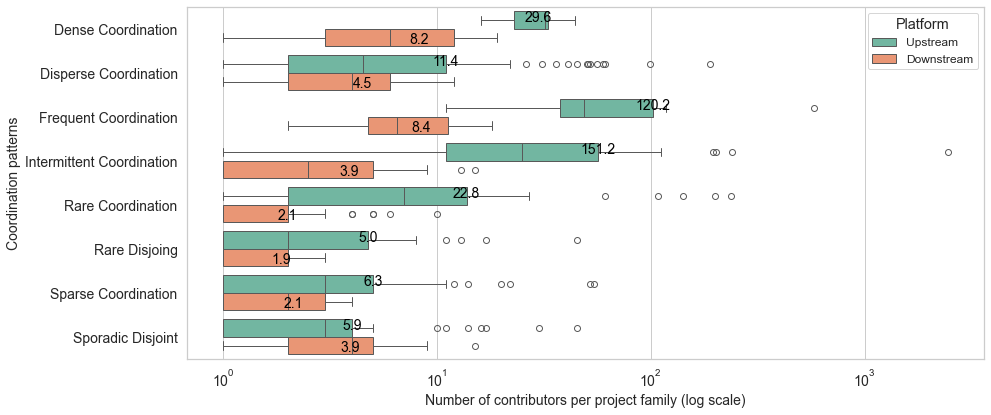

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
file1 = "../RQ1/GH_labelled_with_patterns.csv"
file2 = "../RQ1/HF_labelled_with_patterns_authors.csv"
f2 = "../RQ1/must_exclude_from_all_analysis.csv"

gh = pd.read_csv(file1, encoding='latin1')
hf = pd.read_csv(file2, encoding='latin1')
exclude = pd.read_csv(f2, encoding='latin1')

exclusion = list(exclude['family'].unique())

GH1 = gh[~gh['family'].isin(exclusion)]
HF1 = hf[~hf['family'].isin(exclusion)]

# Merge in groupings
group_gh = GH1.groupby(["owner", "family"]).agg({
    'author_username': "nunique"
}).reset_index()
GH = pd.merge(group_gh, grouping, on='family', how='inner')

group_hf = HF1.groupby(["owner", "family"]).agg({
    'author': "nunique"
}).reset_index()
HF = pd.merge(group_hf, grouping, on='family', how='inner')

# Create contributor counts per model family under each name
gh_authors = GH.groupby(['names', 'family'])['author_username'].sum().reset_index()
hf_authors = HF.groupby(['names', 'family'])['author'].sum().reset_index()

# Add a column to identify the source
gh_authors['platform'] = 'GitHub'
hf_authors['platform'] = 'Hugging Face'

# Rename columns to unify them
gh_authors.rename(columns={'author_username': 'num_authors'}, inplace=True)
hf_authors.rename(columns={'author': 'num_authors'}, inplace=True)

# Combine both datasets
combined = pd.concat([gh_authors, hf_authors], axis=0)

# Rename platform labels
combined['platform'] = combined['platform'].map({
    'GitHub': 'Upstream',
    'Hugging Face': 'Downstream'
})

# --------- TRANSPOSED BOX PLOT ---------
plt.figure(figsize=(14, 6))
ax = sns.boxplot(
    data=combined,
    y='names', x='num_authors',
    hue='platform',
    palette='Set2',
    orient='h'  # horizontal
)

plt.xscale("log")

# Calculate and annotate means manually, keeping them inside the box
for name in combined['names'].unique():
    for platform in ['Upstream', 'Downstream']:
        subset = combined[(combined['names'] == name) & (combined['platform'] == platform)]
        if not subset.empty:
            avg = subset['num_authors'].mean()
            median = subset['num_authors'].median()
            q1 = subset['num_authors'].quantile(0.25)
            q3 = subset['num_authors'].quantile(0.75)
            # Position the label between q1 and q3, or fallback if q1 == q3
            y_pos = list(combined['names'].unique()).index(name)
            y_offset = -0.25 if platform == "Upstream" else 0.25

            # Annotate within the IQR region if possible
            if q1 != q3:
                mean_pos = np.clip(avg, q1, q3)
            else:
                mean_pos = avg  # fallback if box is a line

            ax.text(mean_pos, y_pos + y_offset, f'{avg:.1f}',
                    va='center', ha='center', fontsize=14, color='black')

# Labels, legend, and styling
plt.ylabel("Coordination patterns", fontsize=14)
plt.xlabel("Number of contributors per project family (log scale)", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(title="Platform", fontsize=12)
#plt.title("Contributor Distribution per Model Category (GitHub vs Hugging Face)", fontsize=16)

plt.tight_layout()
plt.savefig("argument3_2.pdf", bbox_inches='tight')
plt.show()
